In [102]:
import numpy as np
import scipy as sp

def Sn_quadrature(n):
    
    def newton_raphson(n, x0, tol=1e-11, max_iter=10000):
        coeffs=sp.special.legendre(n)
        for _ in range(max_iter):
            f = np.polyval(coeffs, x0)
            f_prime = np.polyval(np.polyder(coeffs), x0)
            x1 = x0 - f / f_prime
            if abs(x1 - x0) < tol:
                return x1
            x0 = x1
        
        raise ValueError("Did not converge within the maximum number of iterations")

    x=np.linspace(-1,1,n)
    angles=np.zeros(n)
    weights=np.zeros(n)
    
    for _ in range(n):
        angles[_]=(newton_raphson(n, x0=x[_]))
        weights[_]=(2*(1-angles[_]**2))/((n+1)*(np.polyval(sp.special.legendre(n+1),angles[_])))**2

    return angles,weights

In [113]:
n=32
mu,weight=Sn_quadrature(n)


x=np.linspace(0,10,1000)
h_x=x[1]-x[0]
number_of_mesh_point=len(x)

sigma_t=np.zeros_like(x)
sigma_s=np.zeros_like(x)
sigma_f=np.zeros_like(x)
sigma_a=np.zeros_like(x)

x_1=2
x_2=4
x_3=6
x_4=8
x_5=10

sigma_a_fuel=0.1
sigma_f_fuel=0.1
sigma_s_fuel=0.75
sigma_t_fuel=sigma_a_fuel+sigma_s_fuel+sigma_f_fuel
nu=2.5

sigma_a_reflector=0.1
sigma_f_reflector=0
sigma_s_reflector=0.9
sigma_t_reflector=sigma_a_reflector+sigma_s_reflector+sigma_f_reflector

sigma_a_absorber=0.1
sigma_f_absorber=0
sigma_s_absorber=0.4
sigma_t_absorber=sigma_a_absorber+sigma_s_absorber+sigma_f_absorber

for index,i in enumerate (x):

    if i>=0 and i<x_1:
        sigma_t[index]=sigma_t_reflector
        sigma_s[index]=sigma_s_reflector
        sigma_a[index]=sigma_a_reflector

    elif i>=x_1 and i<x_2:
        sigma_t[index]=sigma_t_fuel
        sigma_s[index]=sigma_s_fuel
        sigma_a[index]=sigma_a_fuel
        sigma_f[index]=sigma_f_fuel

    elif i>=x_2 and i<x_3:
        sigma_t[index]=sigma_t_absorber
        sigma_s[index]=sigma_s_absorber
        sigma_a[index]=sigma_a_absorber

    elif i>=x_3 and i<x_4:
        sigma_t[index]=sigma_t_fuel
        sigma_s[index]=sigma_s_fuel
        sigma_a[index]=sigma_a_fuel
        sigma_f[index]=sigma_f_fuel

    elif i>=x_4 and i<=x_5:
        sigma_t[index]=sigma_t_reflector
        sigma_s[index]=sigma_s_reflector
        sigma_a[index]=sigma_a_reflector



angular_flux=np.ones((number_of_mesh_point,n))
angular_half_flux=np.ones_like(angular_flux)

scalar_flux=np.matmul(angular_flux,weight)
k_old=3

tolerance=10e-10
eigen_tolerance=10e-10

alpha=0

while True:
    #source term calculations 
    source=sigma_s*scalar_flux/(np.pi*4)+nu*sigma_f*scalar_flux/(np.pi*4*k_old)
    old_scalar_flux=scalar_flux


    for weight_index,u in enumerate ( mu[int(n/2):]):
        #iteration for positive mu
        for i in range (len(x)):

            angular_half_flux[i][weight_index]=((1-(1-alpha)*(sigma_t[i]*h_x)/(2*u))/(1+(1+alpha)*(sigma_t[i]*h_x)/(2*u)))*angular_half_flux[i-1][weight_index]+(source[i]*h_x/u)/(1+(1+alpha)*(sigma_t[i]*h_x)/(2*u))
            angular_flux[i][weight_index]=(1+alpha)*angular_half_flux[i][weight_index]/2+(1-alpha)*angular_half_flux[i-1][weight_index]/2
            
    
    for weight_index,u in enumerate ( mu[:int(n/2)]):
        #iteration negative mu      
        for i in reversed (range(len(x))):

            angular_half_flux[i][weight_index]=((1+(1+alpha)*(sigma_t[i]*h_x)/(2*u))/(1-(1-alpha)*(sigma_t[i]*h_x)/(2*u)))*angular_half_flux[i-1][weight_index]-(source[i]*h_x/u)/(1-(1-alpha)*(sigma_t[i]*h_x)/(2*u))
            angular_flux[i][weight_index]=(1-alpha)*angular_half_flux[i][weight_index]/2+(1+alpha)*angular_half_flux[i-1][weight_index]/2
            
            

    
    scalar_flux=np.matmul(angular_flux,weight)
    k=np.linalg.norm(sigma_f*scalar_flux)/np.linalg.norm(sigma_f*old_scalar_flux)
    epsilon=(np.linalg.norm(scalar_flux)-np.linalg.norm(old_scalar_flux))/np.linalg.norm(old_scalar_flux)

    eigen_tol=abs(k-k_old)/k_old
    k_old=k
    
    if epsilon<tolerance and eigen_tol<eigen_tolerance:
            break
        
    print(k)


0.5749927998307004
0.9618941925602127
0.9832521795591462
0.9982105343617518
0.999606899552121
0.999948504087614
0.9999907827513388
0.9999986676371632
0.9999997786027089
0.9999999664145796
0.9999999945822757
0.9999999991598738


Text(0.5, 0, 'x')

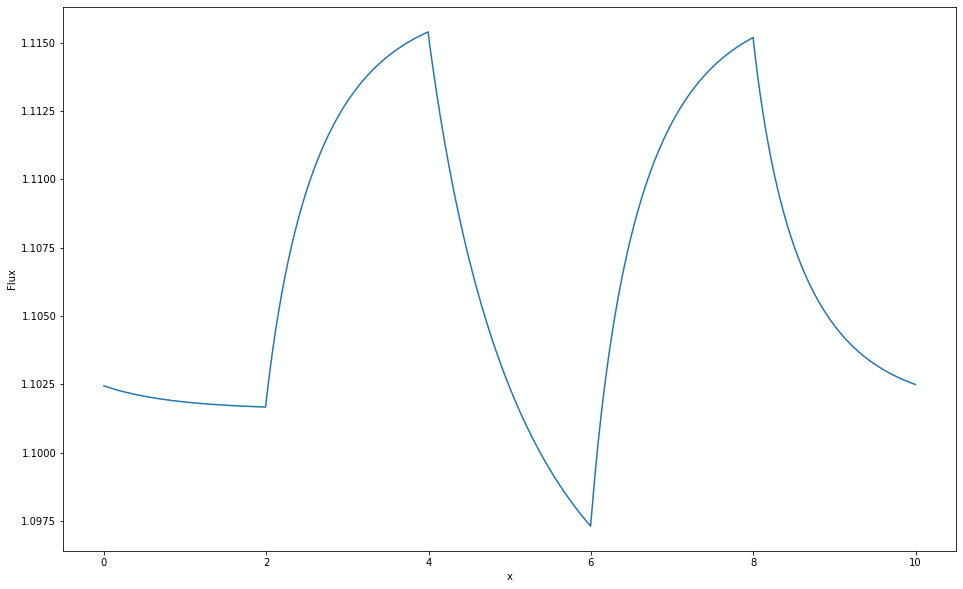

In [114]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,10))
plt.plot(x,scalar_flux)

plt.ylabel("Flux")
plt.xlabel('x')
